In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#set a random seed for replication
seed = 62583
np.random.seed(seed)
#read in training data
df = pd.read_csv('final_dataset.csv')

In [3]:
print(df['GlobalClass'].unique())

['Benign' 'Light Attack' 'Light Benign' 'Heavy Attack' 'Heavy Benign']


In [4]:
df['GlobalClass'].value_counts()


Benign          83183
Heavy Benign    68057
Light Benign    24403
Heavy Attack     5764
Light Attack     2462
Name: GlobalClass, dtype: int64

In [5]:
df['GlobalClass'] = df['GlobalClass'].map({'Benign':0,'Light Benign':0,'Heavy Benign':0, 'Light Attack':1, 'Heavy Attack':2})

Undersampling Benign to balance out the categories more

In [6]:
c0 = df[df['GlobalClass'] == 0]
c1 = df[df['GlobalClass'] == 1]
c2 = df[df['GlobalClass'] == 2]
df_0 = c0.sample(2462)
df_2 = c2.sample(2462)
undersampled_df = pd.concat([df_0, c1, df_2],axis=0)
df = undersampled_df

In [7]:
df['GlobalClass'].value_counts()

0    2462
1    2462
2    2462
Name: GlobalClass, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

#create feature and targets
features = df.drop('GlobalClass', axis=1)
target = df['GlobalClass']
#split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

In [9]:
#size for the sets
print('size of X_train:', X_train.shape)
print('size of X_test:', X_test.shape)
print('size of y_train:', y_train.shape)
print('size of y_test:', y_test.shape)

size of X_train: (5908, 38)
size of X_test: (1478, 38)
size of y_train: (5908,)
size of y_test: (1478,)


In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_classifier = HistGradientBoostingClassifier(class_weight='balanced')
hgb_classifier.fit(X_train,y_train)
y_pred_hgb = hgb_classifier.predict(X_test)
hgb_classifier.score(X_train, y_train)

0.995260663507109

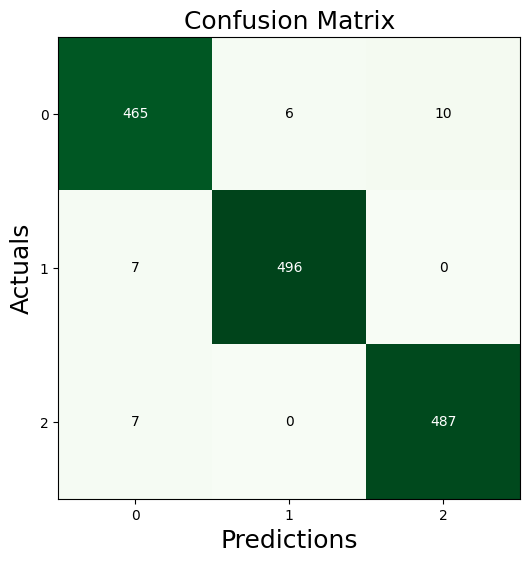

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
cm_hgb = confusion_matrix(y_test, y_pred_hgb)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm_hgb, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
accuracy_score(y_test, y_pred_hgb)

0.979702300405954

In [13]:
pred_prob = hgb_classifier.predict_proba(X_test)
roc_auc_score(y_test, pred_prob, multi_class='ovo')

0.9961052394407729

In [14]:
acc_hgb = cross_val_score(estimator = hgb_classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy of hgb: {:.2f} %".format(acc_hgb.mean()*100))
print("SD of hgb: {:.2f} %".format(acc_hgb.std()*100))
print(classification_report(y_test, y_pred_hgb))

Accuracy of hgb: 97.78 %
SD of hgb: 0.43 %
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       481
           1       0.99      0.99      0.99       503
           2       0.98      0.99      0.98       494

    accuracy                           0.98      1478
   macro avg       0.98      0.98      0.98      1478
weighted avg       0.98      0.98      0.98      1478



In [15]:
from sklearn.model_selection import GridSearchCV
parameters_hgb = [{'max_iter': [1000,1200,1500],
                'learning_rate': [0.1],
                'max_depth' : [25, 50, 75],
                'l2_regularization': [1.5],
                'scoring': ['f1_micro']}]
grid_search_hgb = GridSearchCV(estimator = hgb_classifier,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search_hgb.fit(X_train, y_train)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_  
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)

Best Accuracy of HGB: 97.87 %
Best Parameter of HGB: {'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 25, 'max_iter': 1200, 'scoring': 'f1_micro'}


In [16]:
import pickle

with open('Bell_Balanced.pkl', 'wb') as f:  # open a text file
    pickle.dump(hgb_classifier, f)

In [17]:
from trustee import ClassificationTrustee
from sklearn import tree
import graphviz


trustee = ClassificationTrustee(expert=hgb_classifier)
trustee.fit(X_train, y_train, num_iter=50, num_stability_iter=10, samples_size=0.3, verbose=True)

# Get the best explanation from Trustee
dt, pruned_dt, agreement, reward = trustee.explain()
print(f"Model explanation training (agreement, fidelity): ({agreement}, {reward})")
print(f"Model Explanation size: {dt.tree_.node_count}")
print(f"Top-k Prunned Model explanation size: {pruned_dt.tree_.node_count}")

# Use explanations to make predictions
dt_y_pred = dt.predict(X_test)
pruned_dt_y_pred = pruned_dt.predict(X_test)

# Evaluate accuracy and fidelity of explanations
print("Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, dt_y_pred))
print("Top-k Model explanation global fidelity report:")
print(classification_report(y_pred_hgb, pruned_dt_y_pred))

print("Model explanation score report:")
print(classification_report(y_test, dt_y_pred))
print("Top-k Model explanation score report:")
print(classification_report(y_test, pruned_dt_y_pred))


# Output decision tree to pdf
dot_data = tree.export_graphviz(
    dt,
    class_names=hgb_classifier.target_names,
    feature_names=hgb_classifier.feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("dt_explanation")

# Output pruned decision tree to pdf
dot_data = hgb_classifier.export_graphviz(
    pruned_dt,
    class_names=hgb_classifier.target_names,
    feature_names=hgb_classifier.feature_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("pruned_dt_explation")

Initializing training dataset using HistGradientBoostingClassifier(class_weight='balanced') as expert model
Expert model score: 0.9946881793676532
Initializing Trustee outer-loop with 10 iterations
########## Outer-loop Iteration 0/10 ##########
Initializing Trustee inner-loop with 10 iterations
########## Inner-loop Iteration 0/50 ##########
Sampling 1240 points from training dataset with (4135, 4135) entries


ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values